<center>

# 矩阵乘法运算及其优化

</center>

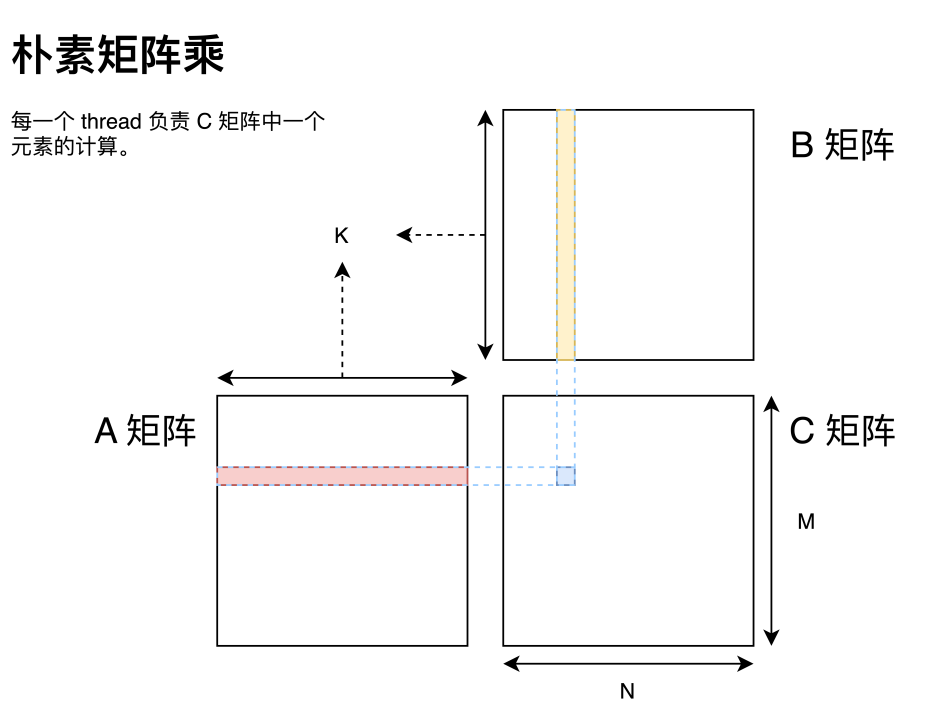

The *foundations* we'll assume throughout this course are:

- Python
- Numpy
- torch

- 资源： 
1. [Matrix 演示网站](http://matrixmultiplication.xyz/)

In [1]:
import numpy as np
import torch

In [63]:
def test_close(a,b): return np.allclose(a, b, rtol=1e-3, atol=1e-5)

## 0. Data

In [3]:
N,K,M = 500, 1024, 10

In [4]:
A = torch.randn(N, K)
B = torch.randn(K, M)
C = torch.zeros(N, M)

In [5]:
A.shape, B.shape, C.shape

(torch.Size([500, 1024]), torch.Size([1024, 10]), torch.Size([500, 10]))

## 1. Native Matrix multiplication

In [6]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar,bc))
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [8]:
%%time
res = matmul(A, B)

CPU times: user 1min 17s, sys: 95.1 ms, total: 1min 18s
Wall time: 1min 18s


## 2. 改进1：NUMBA加速
> JIT即时编译技术是在运行时（runtime）将调用的函数或程序段编译成机器码载入内存，以加快程序的执行。

In [51]:
from numba import njit

In [52]:
@njit
def matmulv1(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar,bc))
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [53]:
Anp = A.numpy()
Bnp = B.numpy()

In [54]:
%%time
_ = matmulv1(Anp, Bnp)

CPU times: user 130 ms, sys: 2.47 ms, total: 133 ms
Wall time: 132 ms


In [55]:
%%time
_ = matmulv1(Anp, Bnp)

CPU times: user 14.1 ms, sys: 183 µs, total: 14.3 ms
Wall time: 14.2 ms


In [56]:
%timeit -n 50 matmulv1(Anp, Bnp)

4.8 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [20]:
from numba import prange

In [22]:
@njit(parallel=True)
def matmulv2(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar,bc))
    for i in prange(ar):
        for j in prange(bc):
            for k in prange(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [57]:
_ = matmulv2(Anp, Bnp)

In [58]:
%timeit -n 50 matmulv2(Anp, Bnp)

1.31 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [64]:
test_close(res, matmulv2(Anp, Bnp))

True

## 3. 改进2：通过Elementwise ops操作降低循环次数

Operators (+,-,\*,/,>,<,==) are usually element-wise.

去掉k层循环，把A中一行和B中一列的循环累加操作替换为Elementwise ops操作：
```python
c[i,j] += a[i,k] * b[k,j]
==>
c[i,j] = (a[i,:] * b[:,j]).sum()
```

In [45]:
@njit(parallel=True)
def matmulv3(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar,bc))
    for i in prange(ar):
        for j in prange(bc):
                c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [59]:
_ = matmulv3(Anp, Bnp)

In [60]:
%timeit -n 50 matmulv3(Anp, Bnp)

1.18 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## 4. 改进3：通过Broadcasting技术进一步压缩循环

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [155]:
a

array([10.,  6., -4.])

In [156]:
a > 0

array([ True,  True, False])

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [157]:
a + 1

array([11.,  7., -3.])

- rank = 2 ?

In [158]:
m

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [159]:
2*m

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

#### Broadcasting a vector to a matrix

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/02.05-broadcasting.png)

We can also broadcast a vector to a matrix:

In [160]:
c = np.array([10.,20,30]); c

array([10., 20., 30.])

In [161]:
m

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [162]:
m.shape,c.shape

((3, 3), (3,))

In [163]:
m + c

array([[11., 22., 33.],
       [14., 25., 36.],
       [17., 28., 39.]])

In [164]:
c + m

array([[11., 22., 33.],
       [14., 25., 36.],
       [17., 28., 39.]])

In [165]:
m + c == c + m 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [170]:
from torch import tensor
m0 = torch.from_numpy(m)
c0 = torch.from_numpy(c)
t = c0.expand_as(m0)

In [50]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [51]:
t.shape

torch.Size([3, 3])

In [52]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [53]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [217]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

> 解释 `stride()`, row to row ，步长为0， column to column 步长为1

In [223]:
m.strides

(24, 8)

In [210]:
c.shape, c[None].shape,c[:,None].shape

((3,), (1, 3), (3, 1))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

- or use `np.newaxis`

In [211]:
c[None].shape,c[...,None].shape

((1, 3), (3, 1))

In [213]:
m + c[:,None]

array([[11., 12., 13.],
       [24., 25., 26.],
       [37., 38., 39.]])

In [214]:
m + c[:,None] - m

array([[10., 10., 10.],
       [20., 20., 20.],
       [30., 30., 30.]])

In [215]:
c[:,None]

array([[10.],
       [20.],
       [30.]])

In [216]:
c

array([10., 20., 30.])

In [175]:
c[:,None].shape

(3, 1)

### Broadcasting Rules

- 规则1：让所有输入数组都向其中形状最长的数组看齐，形状中不足的部分都通过在前面（左侧）补 1
**注：**形状其实就是指the number of dimensions。比如计算a+b，其中a.shape=(2, 2, 3)、b.shape=(2, 3)，那么数组b 将被broadcast为b.shape=(1, 2, 3)
- 规则2：如果两个数组的形状在任何维度上均不匹配，但是某个数组中某一个维度为1，则该维度中形状为1的数组将被拉伸以匹配另一个数组对应维度形状
**注：**这里实际上是保证可以在某一个维度做broadcasting，比如计算a+b，其中 a.shape=(1, 3)、b.shape=(3, 1)，那么根据规则2，这两个数组会boradcast为 a.shape=(3, 3)、b.shape=(3, 3)
- 规则3：如果两个数组的形状在任何维度上均不匹配，且均没有等于1的维度，则会报错。

### Matmul with broadcasting

In [67]:
Anp[1].shape, Bnp.shape

((1024,), (1024, 10))

In [68]:
Anp[1].reshape(-1, 1).shape

(1024, 1)

In [69]:
(Anp[1].reshape(-1, 1) * Bnp).shape

(1024, 10)

In [70]:
(Anp[1].reshape(-1, 1) * Bnp).sum(axis=0)

array([-38.153683,  29.019865,  28.149008, -28.216768, -44.669914,
       -36.891434, -21.358387, -35.30427 , -71.01309 ,  18.294737],
      dtype=float32)

In [71]:
@njit(parallel=True)
def matmulv4(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = np.zeros((ar, bc))
    for i in prange(ar):
        c[i] = (a[i].reshape(-1,1) * b).sum(axis=0)
        # for j in prange(bc):
        #     c[i,j] = (a[i,:] * b[:,j]).sum()
            #for k in prange(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [72]:
_ = matmulv4(Anp, Bnp)

In [74]:
%timeit -n 50 matmulv4(Anp, Bnp)

1.66 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [76]:
test_close(res, matmulv4(Anp, Bnp))

True

## 改进4. 去掉循环（Einstein summation）

einsum全称Einstein summation convention（爱因斯坦求和约定），又称为爱因斯坦标记法，是爱因斯坦1916年提出的一种标记约定，简单的说就是省去求和式中的求和符号；该函数在numpy、tensorflow、pytorch上都有实现，用法基本一样。基本上，可以把einsum看成一种领域特定语言。一旦你理解并能利用einsum，除了不用记忆和频繁查找特定库函数这个好处以外，你还能够更迅速地编写更加紧凑、高效的代码。此外，einsum这样的领域特定语言有时可以编译到高性能代码，事实上，PyTorch最近引入的能够自动生成GPU代码并为特定输入尺寸自动调整代码的张量理解（Tensor Comprehensions）就基于类似einsum的领域特定语言。此外，可以使用opt einsum和tf einsum opt这样的项目优化einsum表达式的构造顺序。

为什么有效？因为我们根本不需要对A进行reshape，最重要的是，乘法不会创建像A[:, np.newaxis] * B这样的临时数组。相反，einsum只需沿着行对乘积进行求和。
> einsum并不总是NumPy中最快的选择。如函数dot和inner经常链接到BLAS例程可以超越einsum在速度方面，tensordot函数也可以与之相比。如果你四处搜索下，就会发现有些帖子的例子einsum似乎很慢，特别是在操作数个输入数组时（例如：https://github.com/numpy/numpy/issues/5366）

例1：矩阵转置

In [83]:
a = torch.arange(6).reshape(2,3)

In [84]:
torch.einsum("ij->ji", a)

tensor([[0, 3],
        [1, 4],
        [2, 5]])

例2：求和

In [85]:
torch.einsum("ij->", a)

tensor(15)

例3： 列求和

In [86]:
torch.einsum("ij->j", a)

tensor([3, 5, 7])

例4： 矩阵-向量乘积

In [87]:
b = torch.arange(3)

In [88]:
torch.einsum("ij,j->i", a, b)

tensor([ 5, 14])

例5：矩阵乘

In [89]:
b = torch.arange(15).reshape(3,5)

In [90]:
torch.einsum("ik,kj->ij", a,b)

tensor([[ 25,  28,  31,  34,  37],
        [ 70,  82,  94, 106, 118]])

例6： batch矩阵相乘

In [91]:
a = torch.randn(3,2,5)
b = torch.randn(3,5,3)
torch.einsum('ijk,ikl->ijl', [a, b])

tensor([[[-2.2711, -1.4083, -0.9735],
         [-0.1964, -0.8956, -2.6275]],

        [[ 1.9814,  2.6162, -0.6002],
         [-1.9711, -0.7980, -0.0875]],

        [[ 5.5980, -3.8218,  1.2668],
         [-1.1954,  0.8863,  1.5366]]])

In [77]:
def matmulv5(a,b): return torch.einsum('ik,kj->ij', a, b)

In [78]:
%timeit matmulv5(A,B)

225 µs ± 7.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
%timeit -n 50 torch.matmul(A, B)

280 µs ± 128 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [80]:
%timeit -n 50 np.matmul(Anp, Bnp)

302 µs ± 208 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## 5. 改进5：GPU并行加速

#### GPU Kernel函数的原理浅析

In [92]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [93]:
res = torch.zeros(N, M)
matmul((0,0), A, B, res)
res

tensor([[-17.8288,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]])

In [94]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [95]:
res = torch.zeros(N, M)
launch_kernel(matmul, N, M, A, B, res)
res

tensor([[-17.8288, -12.6691,  37.2649,  ...,  42.0776, -47.1774, -12.1919],
        [-38.1537,  29.0199,  28.1490,  ..., -35.3043, -71.0131,  18.2947],
        [ -9.0597,  46.4799,  15.7706,  ...,   3.0683,  12.9236,   9.9035],
        ...,
        [ 23.8196, -49.5057,  12.6173,  ...,   9.0780, -38.4126,  10.4630],
        [  2.3184,   3.2012, -51.5571,  ...,  68.4165, -38.5455,   5.3085],
        [ 30.8298,   8.4314,  15.7932,  ...,  -6.5378,  12.2144, -12.6742]])

#### 构建Kernel函数

In [96]:
from numba import cuda

In [ ]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [ ]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [ ]:
A.shape, B.shape

In [ ]:
r = np.zeros((N, M))
m1g,m2g,rg = map(cuda.to_device, (Anp,Bnp,r))

In [ ]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [ ]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

In [ ]:
%timeit -n 10 r=(A.cuda()@B.cuda()).cpu()

## TODO: 整合更多内容

## Summary

| 方法                     | 耗时   |
| ------------------------ | ------ |
| 三重循环                 | 28ms   |
| 两重循环（内积运算）     | 519us  |
| 一层循环（Broadcasting） | 264us  |
| Einstein求和             | 60.4us |
| Numpy                    | 10us   |